Here we illustrate with a toy example the importance of balanced training

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from face_lib.models.losses import ArcFaceLoss
from face_lib.models.arcface import MetricLearningModel
import seaborn as sns
import pandas as pd
from tqdm import tqdm
from evaluation.visualize import (
    plot_rejection_scores,
)
from torch.utils.data import DataLoader
from utils_notebooks import predict_features, compute_distance_and_visualize

from pathlib import Path
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning import Trainer
import datetime
from face_lib.models.scf import SphereConfidenceFace, SoftmaxWeights
from face_lib.models.heads import SCFHead
from face_lib.models.losses import KLDiracVMF
import pytorch_lightning
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning import Trainer

%load_ext autoreload
%autoreload 2

### 1. Train arcface on mnist

In [3]:
# 1. Define simple model
class Backbone(nn.Module):
    def __init__(self, num_features=128):
        super(Backbone, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.bn1 = nn.BatchNorm2d(
            32,
            eps=1e-05,
        )
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.bn2 = nn.BatchNorm2d(
            64,
            eps=1e-05,
        )
        self.features = nn.BatchNorm1d(num_features, eps=1e-05)
        self.fc1 = nn.Linear(9216, num_features)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.bn2(x)
        x = torch.flatten(x, 1)
        sig_x = x
        x = self.fc1(x)
        x = self.features(x)
        x = F.normalize(x, p=2.0, dim=1)
        output = {
            "feature": x,
            "bottleneck_feature": sig_x,
        }
        return output


def train_arcface(arcface_model, dirpath: str, run_name: str = "", max_epoch=200):
    dirpath = Path(dirpath)
    wab_logger = WandbLogger(
        # api_key="agnHNC2vEt7tOxnnxT4LzYf7Y",
        project="ToyArcFaceMnist",
        name=run_name,
    )

    checkpoint_callback = ModelCheckpoint(
        monitor="val_loss",
        dirpath=dirpath / "ckpt",
        filename="{epoch:02d}-{val_loss:.2f}",
    )
    # initialize trainer, use one GPU for training
    trainer = Trainer(
        max_epochs=max_epoch,
        default_root_dir=dirpath,  # "/app/outputs/arcface_mnist",
        accelerator="gpu",
        devices=[0],
        benchmark=True,
        check_val_every_n_epoch=5,
        logger=wab_logger,
        callbacks=[checkpoint_callback],
    )

    # fit the model
    trainer.fit(arcface_model)
    del wab_logger


def compute_cosine_sim(arcface_model, train_dl, test_dl, file_name: str):
    predicted_train_features, train_labels = predict_features(arcface_model, train_dl)
    softmax_weights = F.normalize(arcface_model.softmax_weights, dim=1)
    wc = softmax_weights[train_labels, :].detach().cpu()
    predicted_train_features = torch.tensor(predicted_train_features)
    cosine_sim_train = torch.sum(predicted_train_features * wc, dim=1, keepdim=True)
    cosine_sim_train = cosine_sim_train[:, 0].numpy()
    np.save(f"outputs/train_{file_name}_cosine_sim.npy", cosine_sim_train)

    predicted_test_features, test_labels = predict_features(arcface_model, test_dl)
    predicted_test_features = torch.tensor(predicted_test_features)
    wc_test = softmax_weights[test_labels, :].detach().cpu()
    cosine_sim_test = torch.sum(predicted_test_features * wc_test, dim=1, keepdim=True)
    cosine_sim_test = cosine_sim_test[:, 0].numpy()
    np.save(f"outputs/test_{file_name}_cosine_sim.npy", cosine_sim_test)


def predict_accuracy(features, labels, softmax_weights):
    predictions = np.argmax(features @ softmax_weights.T, axis=-1)
    return np.mean(predictions == labels)


def load_arcface_model(
    mnist_ds_train, mnist_ds_test, checkpoint_path: str, visualize: bool = False
):

    NUM_FEATURES = 2
    backbone_model = Backbone(num_features=NUM_FEATURES)
    arcface_loss = ArcFaceLoss()
    arcface_model = MetricLearningModel(
        backbone_model,
        arcface_loss,
        num_labels=10,
        train_set=mnist_ds_train,
        val_set=mnist_ds_test,
        num_features=NUM_FEATURES,
    )
    arcface_model = arcface_model.load_from_checkpoint(checkpoint_path)

    predicted_features, image_labels = predict_features(
        arcface_model, arcface_model.val_dataloader()
    )

    softmax_weights = arcface_model.softmax_weights.detach().cpu()
    softmax_weights = F.normalize(softmax_weights, dim=1).numpy()
    if visualize:
        dists = compute_distance_and_visualize(
            predicted_features, image_labels, softmax_weights, num_features=NUM_FEATURES
        )
    print(
        f"Test accuracy: {predict_accuracy(predicted_features, image_labels, softmax_weights)}"
    )
    # print(f"Average distance: {np.mean(dists)}")
    return arcface_model


def load_scf_model(mnist_ds_train, mnist_ds_test, scf_path, arcface_path, radius=1):
    optimizer_params = {
        "optimizer_path": "torch.optim",
        "optimizer_name": "AdamW",
        "params": {"lr": 3e-2, "weight_decay": 0.01},
    }
    scheduler_params = {
        "scheduler": "StepLR",
        "params": {"step_size": 10, "gamma": 0.5},
        "interval": "step",
        "frequency": 1,
    }
    arcface_model = load_arcface_model(mnist_ds_train, mnist_ds_test, arcface_path)
    arcface_model = arcface_model.load_from_checkpoint(arcface_path)
    backbone = arcface_model.backbone
    head = SCFHead(convf_dim=28 * 28, latent_vector_size=10, activation="sigmoid")
    softmax_weights = SoftmaxWeights(
        softmax_weights_path=f"outputs/softmax_weights.pt", radius=radius
    )
    scf_loss = KLDiracVMF(z_dim=2, radius=radius)
    scf_model = SphereConfidenceFace(
        backbone=backbone,
        head=head,
        scf_loss=scf_loss,
        optimizer_params=optimizer_params,
        scheduler_params=scheduler_params,
        softmax_weights=softmax_weights,
        permute_batch=False,
        predict_kappa_by_input=True,
    )

    scf_model.load_state_dict(torch.load(scf_path)["state_dict"])
    return scf_model


def train_scf(
    run_name,
    mnist_ds_train,
    mnist_ds_test,
    arcface_path: str,
    batch_size=400,
    radius=1,
    max_epoch=100,
    num_features=2,
):

    optimizer_params = {
        "optimizer_path": "torch.optim",
        "optimizer_name": "AdamW",
        "params": {"lr": 3e-2, "weight_decay": 0.01},
    }
    scheduler_params = {
        "scheduler": "StepLR",
        "params": {"step_size": 10, "gamma": 0.5},
        "interval": "step",
        "frequency": 1,
    }
    backbone_model = Backbone(num_features=num_features)
    arcface_loss = ArcFaceLoss()

    arcface_model = MetricLearningModel(
        backbone_model,
        arcface_loss,
        num_labels=10,
        train_set=mnist_ds_train,
        val_set=mnist_ds_test,
        num_features=num_features,
    )
    arcface_model = arcface_model.load_from_checkpoint(arcface_path)
    backbone = arcface_model.backbone
    head = SCFHead(convf_dim=28 * 28, latent_vector_size=10, activation="sigmoid")
    softmax_weights = SoftmaxWeights(
        softmax_weights_path=f"outputs/softmax_weights.pt", radius=radius
    )
    scf_loss = KLDiracVMF(z_dim=2, radius=radius)
    scf_model = SphereConfidenceFace(
        backbone=backbone,
        head=head,
        scf_loss=scf_loss,
        optimizer_params=optimizer_params,
        scheduler_params=scheduler_params,
        softmax_weights=softmax_weights,
        permute_batch=False,
        predict_kappa_by_input=True,
    )

    train_dl = DataLoader(
        mnist_ds_train,
        batch_size=batch_size,
        shuffle=True,
        drop_last=False,
        num_workers=32,
    )

    wab_logger = WandbLogger(project="SCFMnist", name=run_name)
    now = datetime.datetime.now()
    checkpoint_callback = ModelCheckpoint(
        every_n_epochs=10,
        dirpath=f"/app/outputs/{run_name}/ckpt/{str(now)}",
        save_last=True,
    )
    lr_callback = pytorch_lightning.callbacks.LearningRateMonitor(
        logging_interval="step"
    )
    # initialize trainer, use one GPU for training
    trainer = Trainer(
        max_epochs=max_epoch,
        default_root_dir=f"/app/outputs/{run_name}/ckpt/{str(now)}",
        accelerator="gpu",
        devices=[0],
        logger=wab_logger,
        callbacks=[checkpoint_callback, lr_callback],
    )

    # fit the model
    trainer.fit(scf_model, train_dl)
    del wab_logger

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
)
mnist_ds_train = datasets.MNIST(
    root="/app/datasets/mnist", train=True, download=True, transform=transform
)
mnist_ds_test = datasets.MNIST(
    root="/app/datasets/mnist", train=False, download=True, transform=transform
)

#### 1.1 Train Arcface on full ds

In [5]:
NUM_FEATURES = 2

backbone_model = Backbone(num_features=NUM_FEATURES)
arcface_loss = ArcFaceLoss()

arcface_model = MetricLearningModel(
    backbone_model,
    arcface_loss,
    num_labels=10,
    train_set=mnist_ds_train,
    val_set=mnist_ds_test,
    batch_size=400,
    num_workers=4,
    num_features=NUM_FEATURES,
)
exp_name = "arcface_full_mnist"
# train_arcface(arcface_model, f"/app/outputs/{exp_name}", exp_name, max_epoch=100)

/home/l.erlygin/miniconda/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'backbone' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['backbone'])`.
  rank_zero_warn(
/home/l.erlygin/miniconda/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(


##### Cosine similarity distribution

/home/l.erlygin/miniconda/lib/python3.9/site-packages/lightning_fabric/utilities/cloud_io.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_locat

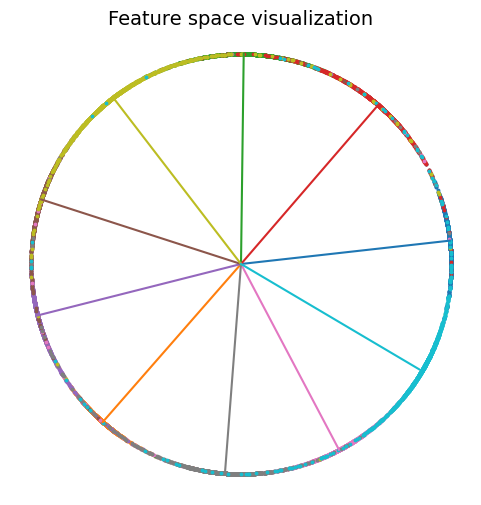

  0%|          | 0/469 [00:00<?, ?it/s]

Test accuracy: 0.8849


100%|██████████| 79/79 [00:00<00:00, 80.74it/s]
/tmp/ipykernel_306345/999290897.py:26: RuntimeWarning: invalid value encountered in arccos
  "test": (np.arccos(cosine_sim_test) / (2 * np.pi)) * 360,
/tmp/ipykernel_306345/999290897.py:27: RuntimeWarning: invalid value encountered in arccos
  "train": (np.arccos(cosine_sim_train) / (2 * np.pi)) * 360,


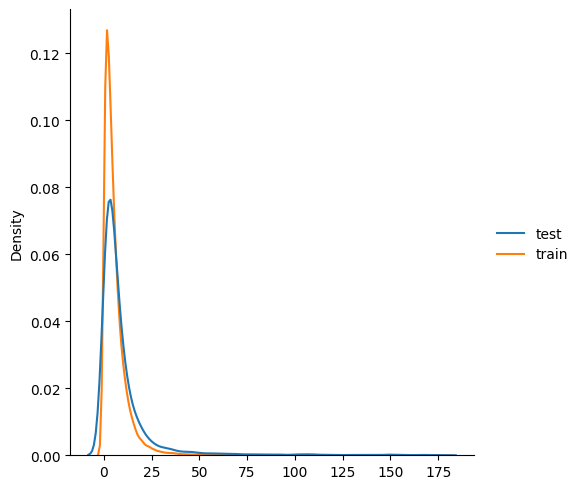

In [6]:
train_dl = DataLoader(
    mnist_ds_train,
    batch_size=128,
    shuffle=False,
    drop_last=False,
    num_workers=32,
)
test_dl = DataLoader(
    mnist_ds_test,
    batch_size=128,
    shuffle=False,
    drop_last=False,
    num_workers=32,
)
arcface_model = load_arcface_model(
    mnist_ds_train,
    mnist_ds_test,
    "/app/outputs/arcface_full_mnist/ckpt/epoch=89-val_loss=1.24.ckpt",
    visualize=True,
)
file_name = "full_mnist"
compute_cosine_sim(arcface_model, train_dl, test_dl, file_name)
cosine_sim_train = np.load(f"outputs/train_{file_name}_cosine_sim.npy")
cosine_sim_test = np.load(f"outputs/test_{file_name}_cosine_sim.npy")
data = {
    "test": (np.arccos(cosine_sim_test) / (2 * np.pi)) * 360,
    "train": (np.arccos(cosine_sim_train) / (2 * np.pi)) * 360,
}
sns.displot(
    data,
    kind="kde",
    log_scale=False,
    common_norm=False,
)

#### 1.2 Train Arcface on filtered ds  

In [7]:
np.sum((np.arccos(cosine_sim_train) / (2 * np.pi)) * 360 > 18), len(cosine_sim_train)

/tmp/ipykernel_306345/2342528981.py:1: RuntimeWarning: invalid value encountered in arccos
  np.sum((np.arccos(cosine_sim_train) / (2 * np.pi)) * 360 > 18), len(cosine_sim_train)


(2751, 60000)

In [8]:
EPS = 1e-6
angle = 18
angles = (np.arccos(np.clip(cosine_sim_train, -1.0 + EPS, 1.0 - EPS)) / (np.pi)) * 180
mnist_ds_train_filtered = torch.utils.data.Subset(
    mnist_ds_train,
    np.where(angles < angle)[0],
)
len(mnist_ds_train_filtered)

57249

In [9]:
NUM_FEATURES = 2

backbone_model = Backbone(num_features=NUM_FEATURES)
arcface_loss = ArcFaceLoss()

arcface_model = MetricLearningModel(
    backbone_model,
    arcface_loss,
    num_labels=10,
    train_set=mnist_ds_train_filtered,
    val_set=mnist_ds_test,
    batch_size=400,
    num_workers=4,
    num_features=NUM_FEATURES,
)
exp_name = f"arcface_angle_{angle}_filtered_mnist"
# train_arcface(arcface_model, f"/app/outputs/{exp_name}", exp_name, max_epoch=100)

/home/l.erlygin/miniconda/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'backbone' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['backbone'])`.
  rank_zero_warn(
/home/l.erlygin/miniconda/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(


/home/l.erlygin/miniconda/lib/python3.9/site-packages/lightning_fabric/utilities/cloud_io.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_locat

Test accuracy: 0.9208


100%|██████████| 79/79 [00:01<00:00, 76.46it/s]
/tmp/ipykernel_306345/2242598020.py:26: RuntimeWarning: invalid value encountered in arccos
  "train": (np.arccos(cosine_sim_train) / (2 * np.pi)) * 360,


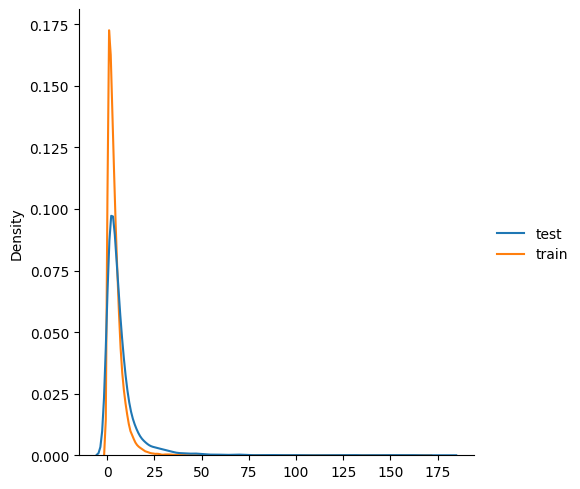

In [10]:
train_dl = DataLoader(
    mnist_ds_train_filtered,
    batch_size=128,
    shuffle=False,
    drop_last=False,
    num_workers=32,
)
test_dl = DataLoader(
    mnist_ds_test,
    batch_size=128,
    shuffle=False,
    drop_last=False,
    num_workers=32,
)
arcface_model = load_arcface_model(
    mnist_ds_train_filtered,
    mnist_ds_test,
    "/app/outputs/arcface_angle_18_filtered_mnist/ckpt/epoch=99-val_loss=1.09.ckpt",
)
file_name = f"angle_{angle}_filtered_mnist"
compute_cosine_sim(arcface_model, train_dl, test_dl, file_name)
cosine_sim_train = np.load(f"outputs/train_{file_name}_cosine_sim.npy")
cosine_sim_test = np.load(f"outputs/test_{file_name}_cosine_sim.npy")
data = {
    "test": (np.arccos(cosine_sim_test) / (2 * np.pi)) * 360,
    "train": (np.arccos(cosine_sim_train) / (2 * np.pi)) * 360,
}
sns.displot(
    data,
    kind="kde",
    log_scale=False,
    common_norm=False,
)

#### 1.3 Compute error probabilities on train MNIST and clean MNIST
Here we use arcface model trained on clean MNIST

In [11]:
arcface_model = load_arcface_model(
    mnist_ds_train,
    mnist_ds_test,
    "/app/outputs/arcface_angle_18_filtered_mnist/ckpt/epoch=99-val_loss=1.09.ckpt",
)
arcface_model.eval()

train_dl = DataLoader(
    mnist_ds_train,
    batch_size=128,
    shuffle=False,
    drop_last=False,
    num_workers=32,
)
train_dl_filtered = DataLoader(
    mnist_ds_train_filtered,
    batch_size=128,
    shuffle=False,
    drop_last=False,
    num_workers=32,
)

predicted_train_features, train_labels = predict_features(arcface_model, train_dl)
predicted_train_features_filtered, train_labels_filtered = predict_features(
    arcface_model, train_dl_filtered
)
softmax_weights = (
    F.normalize(arcface_model.softmax_weights, dim=1).detach().cpu().numpy()
)

/home/l.erlygin/miniconda/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'backbone' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['backbone'])`.
  rank_zero_warn(
/home/l.erlygin/miniconda/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/l.erlygin/miniconda/lib/python3.9/site-packages/lightning_fabric/utilities/cloud_io.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch

Test accuracy: 0.9208


100%|██████████| 448/448 [00:01<00:00, 240.03it/s]


In [12]:
arcface_model

MetricLearningModel(
  (backbone): Backbone(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (features): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc1): Linear(in_features=9216, out_features=2, bias=True)
  )
  (loss): ArcFaceLoss()
)

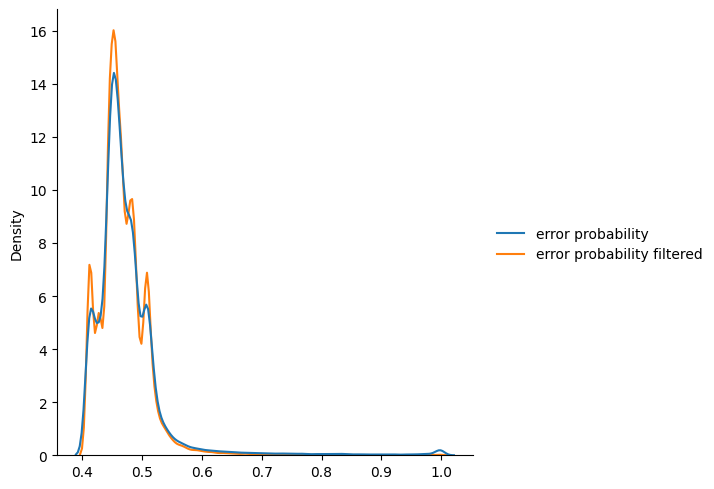

In [13]:
cosine_sim = predicted_train_features @ softmax_weights.T
s = 5
p_z = np.exp(s * cosine_sim)
p_z_filtered = np.exp(s * predicted_train_features_filtered @ softmax_weights.T)
true_class_prob = p_z[np.arange(p_z.shape[0]), train_labels] / np.sum(p_z, axis=1)
true_class_prob_filtered = p_z_filtered[
    np.arange(p_z_filtered.shape[0]), train_labels_filtered
] / np.sum(p_z_filtered, axis=1)

data = {
    "error probability": 1 - true_class_prob,
    "error probability filtered": 1 - true_class_prob_filtered,
}
sns.displot(
    data,
    kind="kde",
    log_scale=False,
    common_norm=False,
)

In [14]:
np.mean(1 - true_class_prob), np.mean(1 - true_class_prob_filtered)

(0.47488457, 0.46801722)

In [15]:
np.median(1 - true_class_prob), np.median(1 - true_class_prob_filtered)

(0.4637637, 0.46135283)

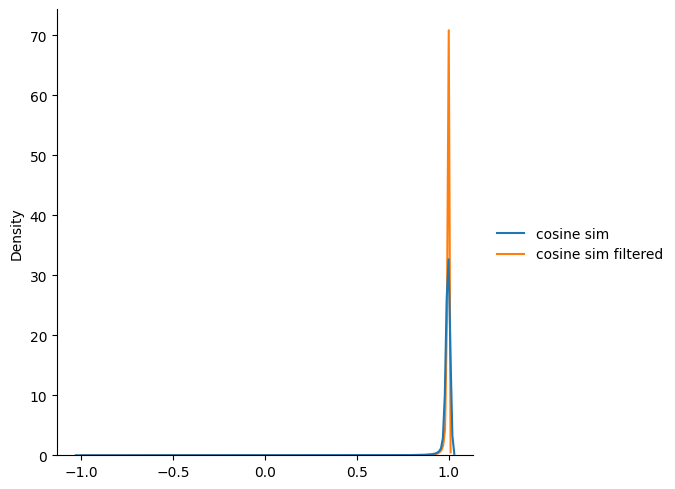

In [16]:
cosine_sim = (predicted_train_features @ softmax_weights.T)[
    np.arange(predicted_train_features.shape[0]), train_labels
]
cosine_sim_filtered = (predicted_train_features_filtered @ softmax_weights.T)[
    np.arange(predicted_train_features_filtered.shape[0]), train_labels_filtered
]
data = {
    "cosine sim": cosine_sim,
    "cosine sim filtered": cosine_sim_filtered,
}
sns.displot(
    data,
    kind="kde",
    log_scale=False,
    common_norm=False,
)

#### 2.1 Train SCF on full mnist

In [17]:
# arcface_model = load_arcface_model(
#     mnist_ds_train,
#     mnist_ds_test,
#     "/app/outputs/arcface_angle_18_filtered_mnist/ckpt/epoch=99-val_loss=1.09.ckpt",
# )
# arcface_model.eval()
# torch.save(arcface_model.softmax_weights.detach().cpu(), "outputs/softmax_weights.pt")

In [18]:
# train_scf('scf_full_mnist', mnist_ds_train, mnist_ds_test, '/app/outputs/arcface_angle_18_filtered_mnist/ckpt/epoch=99-val_loss=1.09.ckpt')

#### 2.2 Train SCF on filtered dataset

In [19]:
exp_name = f"scf_angle_{angle}_filtered_mnist"
# train_scf(
#     exp_name,
#     mnist_ds_train_filtered,
#     mnist_ds_test,
#     "/app/outputs/arcface_angle_18_filtered_mnist/ckpt/epoch=99-val_loss=1.09.ckpt",
# )

#### 2.3 Train SCF on DirtyMNIST

In [55]:
import ddu_dirty_mnist

# transform_dirty = transforms.Compose(
#     [transforms.Normalize((0.1307,), (0.3081,))]
# )
dirty_mnist_train = ddu_dirty_mnist.DirtyMNIST(
    root="/app/datasets/dirty_mnist", train=True, download=True
)
dirty_mnist_test = ddu_dirty_mnist.DirtyMNIST(
    root="/app/datasets/dirty_mnist", train=False, download=True
)
len(dirty_mnist_train), len(dirty_mnist_test)

/home/l.erlygin/miniconda/lib/python3.9/site-packages/ddu_dirty_mnist/dirty_mnist.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data = torch.load(self.resource_p

(120000, 70000)

In [56]:
exp_name = f"scf_dirty_mnist"
train_scf(
    exp_name,
    dirty_mnist_train,
    mnist_ds_test,
    "/app/outputs/arcface_angle_18_filtered_mnist/ckpt/epoch=99-val_loss=1.09.ckpt",
)

/home/l.erlygin/miniconda/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'backbone' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['backbone'])`.
  rank_zero_warn(
/home/l.erlygin/miniconda/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/l.erlygin/miniconda/lib/python3.9/site-packages/lightning_fabric/utilities/cloud_io.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch

Epoch 99: 100%|██████████| 300/300 [00:07<00:00, 41.51it/s, v_num=xv0i, train_loss=0.101]   

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 300/300 [00:07<00:00, 41.43it/s, v_num=xv0i, train_loss=0.101]


#### 3.1 Compare UE methods

In [41]:
arcface_path = (
    "/app/outputs/arcface_angle_18_filtered_mnist/ckpt/epoch=99-val_loss=1.09.ckpt"
)
scf_full = load_scf_model(
    mnist_ds_train,
    mnist_ds_test,
    scf_path="/app/outputs/scf_full_mnist/ckpt/2024-08-30 15:28:19.199679/epoch=99-step=15000.ckpt",
    arcface_path=arcface_path,
)

/home/l.erlygin/miniconda/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'backbone' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['backbone'])`.
  rank_zero_warn(
/home/l.erlygin/miniconda/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/l.erlygin/miniconda/lib/python3.9/site-packages/lightning_fabric/utilities/cloud_io.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch

Test accuracy: 0.9208


In [42]:
(2700 / 60000) * 100

4.5

In [43]:
def compute_kappa(scf_model, dataset):
    mnist_dl = DataLoader(
        dataset,
        batch_size=128,
        shuffle=False,
        drop_last=False,
        num_workers=32,
    )
    scf_model.eval()
    features = []
    labels = []
    kappa = []
    for batch in tqdm(mnist_dl):
        labels.append(batch[1].numpy())
        predictions = scf_model(batch[0])
        features.append(predictions[0].detach().cpu().numpy())
        kappa.append(torch.exp(predictions[1]).detach().cpu().numpy())
    labels = np.concatenate(labels)
    features = np.concatenate(features, axis=0)
    kappa = np.concatenate(kappa, axis=0)[:, 0]
    return features, labels, kappa

In [44]:
full_features, full_labels, full_kappa = compute_kappa(scf_full, mnist_ds_test)

100%|██████████| 79/79 [00:04<00:00, 16.26it/s]


In [45]:
scf_filtered = load_scf_model(
    mnist_ds_train,
    mnist_ds_test,
    scf_path="/app/outputs/scf_angle_18_filtered_mnist/ckpt/2024-08-30 15:36:36.239175/epoch=99-step=14400.ckpt",
    arcface_path=arcface_path,
)

100%|██████████| 25/25 [00:00<00:00, 26.82it/s]
/tmp/ipykernel_306345/4288942580.py:155: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  scf_model.load_state_dict(torch.load(s

Test accuracy: 0.9208


In [46]:
filtered_features, filtered_labels, filtered_kappa = compute_kappa(
    scf_filtered, mnist_ds_test
)

100%|██████████| 79/79 [00:04<00:00, 16.21it/s]


In [57]:
scf_dirty_mnist = load_scf_model(
    dirty_mnist_train,
    mnist_ds_test,
    scf_path="/app/outputs/scf_dirty_mnist/ckpt/2024-09-16 11:36:51.218096/epoch=99-step=30000.ckpt",
    arcface_path=arcface_path,
)
dirty_mnist_features, dirty_mnist_labels, dirty_mnist_kappa = compute_kappa(
    scf_dirty_mnist, mnist_ds_test
)

100%|██████████| 25/25 [00:00<00:00, 25.15it/s]
/tmp/ipykernel_306345/4288942580.py:155: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  scf_model.load_state_dict(torch.load(s

Test accuracy: 0.9208


100%|██████████| 79/79 [00:05<00:00, 15.14it/s]


In [58]:
arcface_model = load_arcface_model(
    mnist_ds_train,
    mnist_ds_test,
    arcface_path,
)
softmax_weights = (
    torch.nn.functional.normalize(arcface_model.softmax_weights, dim=1)
    .detach()
    .cpu()
    .numpy()
)

100%|██████████| 25/25 [00:00<00:00, 25.51it/s]

Test accuracy: 0.9208


#### TAR@FAR Curve

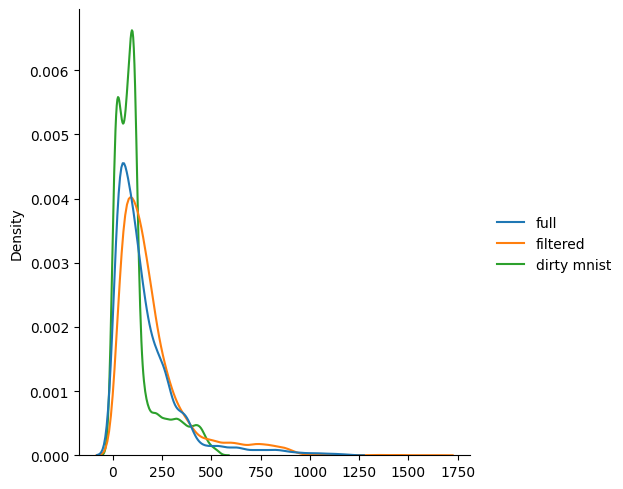

In [59]:
sns.displot(
    {"full": full_kappa, "filtered": filtered_kappa, "dirty mnist": dirty_mnist_kappa},
    kind="kde",
    log_scale=False,
    common_norm=False,
)

#### Train scf on augmented data

/home/l.erlygin/miniconda/lib/python3.9/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


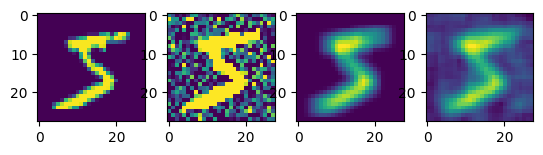

In [60]:
from torchvision.transforms.v2 import GaussianNoise, GaussianBlur
from torchvision.transforms import v2

mnist_ds_train_vis = datasets.MNIST(
    root="/app/datasets/mnist", train=True, download=True
)
transform = v2.Compose([v2.ToTensor(), v2.Normalize((0.1307,), (0.3081,))])
transform_nose = v2.Compose(
    [
        v2.ToTensor(),
        v2.Normalize((0.1307,), (0.3081,)),
        GaussianNoise(mean=0.6, sigma=0.4),
    ]
)
transform_blur = v2.Compose(
    [
        v2.ToTensor(),
        v2.Normalize((0.1307,), (0.3081,)),
        GaussianBlur(kernel_size=5, sigma=5),
    ]
)
transform_nose_blur = v2.Compose(
    [
        v2.ToTensor(),
        v2.Normalize((0.1307,), (0.3081,)),
        v2.RandomApply(
            [
                GaussianNoise(mean=0.3, sigma=0.5),
                GaussianBlur(kernel_size=5, sigma=(1, 5)),
            ],
            p=0.5,
        ),
    ]
)
image_id = 0
image = transform(mnist_ds_train_vis[image_id][0])[0, ...]
image_nose = transform_nose(mnist_ds_train_vis[image_id][0])[0, ...]
image_blur = transform_blur(mnist_ds_train_vis[image_id][0])[0, ...]
image_nose_blur = transform_nose_blur(mnist_ds_train_vis[image_id][0])[0, ...]

fig, axes = plt.subplots(1, 4)  # figsize=(1.5 * num_col, 2 * num_row)#
axes[0].imshow(image)
axes[1].imshow(image_nose)
axes[2].imshow(image_blur)
axes[3].imshow(image_nose_blur)

In [61]:
transform_nose_blur = v2.Compose(
    [
        v2.ToTensor(),
        v2.Normalize((0.1307,), (0.3081,)),
        v2.RandomApply(
            [
                GaussianNoise(mean=0.3, sigma=0.5),
                GaussianBlur(kernel_size=5, sigma=(1, 5)),
            ],
            p=0.5,
        ),
    ]
)

cosine_sim_train = np.load(f"outputs/train_full_mnist_cosine_sim.npy")
mnist_ds_train_aug = datasets.MNIST(
    root="/app/datasets/mnist", train=True, download=True, transform=transform_nose_blur
)
EPS = 1e-6
angle = 18
angles = (np.arccos(np.clip(cosine_sim_train, -1.0 + EPS, 1.0 - EPS)) / (np.pi)) * 180
mnist_ds_train_filtered_aug = torch.utils.data.Subset(
    mnist_ds_train_aug,
    np.where(angles < angle)[0],
)
len(mnist_ds_train_filtered_aug)

57249

In [62]:
exp_name = f"scf_angle_{angle}_filtered_aug_mnist"
# train_scf(
#     exp_name,
#     mnist_ds_train_filtered_aug,
#     mnist_ds_test,
#     "/app/outputs/arcface_angle_18_filtered_mnist/ckpt/epoch=99-val_loss=1.09.ckpt",
# )

In [63]:
scf_aug = load_scf_model(
    mnist_ds_train,
    mnist_ds_test,
    scf_path="/app/outputs/scf_angle_18_filtered_aug_mnist/ckpt/2024-09-02 11:02:15.881051/epoch=99-step=14400.ckpt",
    arcface_path=arcface_path,
)
aug_features, aug_labels, aug_kappa = compute_kappa(scf_aug, mnist_ds_test)

/home/l.erlygin/miniconda/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'backbone' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['backbone'])`.
  rank_zero_warn(
/home/l.erlygin/miniconda/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/l.erlygin/miniconda/lib/python3.9/site-packages/lightning_fabric/utilities/cloud_io.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch

Test accuracy: 0.9208


100%|██████████| 79/79 [00:05<00:00, 14.29it/s]


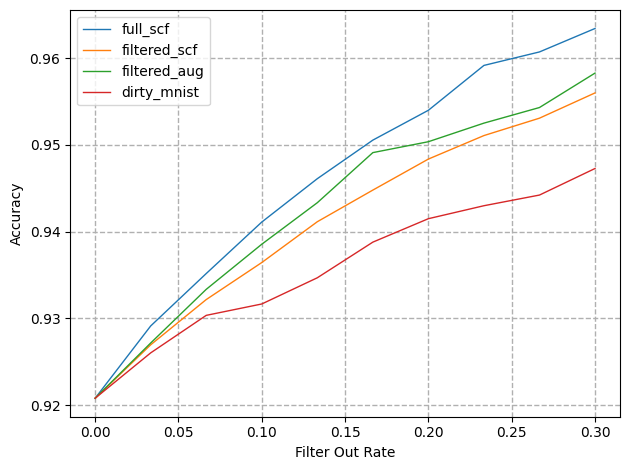

In [64]:
fractions = [0, 0.3, 10]
fractions_linspace = np.linspace(fractions[0], fractions[1], fractions[2])

metric_scores = []
model_names = ["full_scf", "filtered_scf", "filtered_aug", "dirty_mnist"]
for features, labels, kappa in [
    (full_features, full_labels, full_kappa),
    (filtered_features, filtered_labels, filtered_kappa),
    (aug_features, aug_labels, aug_kappa),
    (dirty_mnist_features, dirty_mnist_labels, dirty_mnist_kappa),
]:

    accuracies = []
    unc_indexes = np.argsort(-kappa)
    for fraction in fractions_linspace:
        good_idx = unc_indexes[: int((1 - fraction) * kappa.shape[0])]
        accuracies.append(
            predict_accuracy(
                features=features[good_idx],
                labels=labels[good_idx],
                softmax_weights=softmax_weights,
            )
        )

    metric_scores.append((fractions_linspace, accuracies))

metric_pretty_name = "Accuracy"
fig, rejection_metric_values = plot_rejection_scores(
    scores=metric_scores,
    names=model_names,
    y_label=f"{metric_pretty_name}",
)
fig.show()

In [133]:
# predicted_test_features, test_labels = predict_features(arcface_model, test_dl)
pairs = pd.read_csv("outputs/pairs.csv")


def distance_function(X_1, X_2):
    return np.sum(X_1 * X_2, axis=1)


p1 = pairs["first_template"].values
p2 = pairs["second_template"].values

batch_size = 10000
steps = int(np.ceil(len(p1) / batch_size))
scores = []
unc_full = []
unc_filtered = []
unc_aug = []
for id in tqdm(range(steps), "Verification"):
    feat1 = full_features[p1[id * batch_size : (id + 1) * batch_size]]
    feat2 = full_features[p2[id * batch_size : (id + 1) * batch_size]]
    unc1 = full_kappa[p1[id * batch_size : (id + 1) * batch_size]]
    unc2 = full_kappa[p2[id * batch_size : (id + 1) * batch_size]]
    unc3 = filtered_kappa[p1[id * batch_size : (id + 1) * batch_size]]
    unc4 = filtered_kappa[p2[id * batch_size : (id + 1) * batch_size]]
    unc5 = aug_kappa[p1[id * batch_size : (id + 1) * batch_size]]
    unc6 = aug_kappa[p2[id * batch_size : (id + 1) * batch_size]]
    unc_full.extend(-np.minimum(unc1, unc2))
    unc_filtered.extend(-np.minimum(unc3, unc4))
    unc_aug.extend(-np.minimum(unc5, unc6))
    scores.extend(distance_function(feat1, feat2))
scores = np.array(scores)
unc_full = np.array(unc_full)
unc_filtered = np.array(unc_filtered)
unc_aug = np.array(unc_aug)

Verification: 100%|██████████| 5000/5000 [00:12<00:00, 396.81it/s]


In [ ]:
# from utils_notebooks import tar_far_curve
# tar_far_curve(scores, pairs)

100%|██████████| 5/5 [00:26<00:00,  5.26s/it]


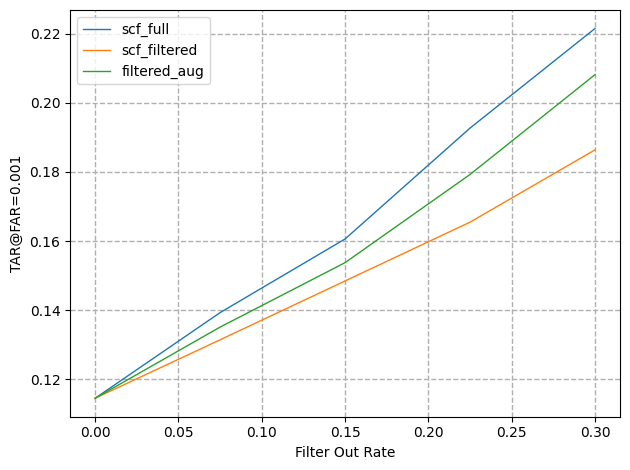

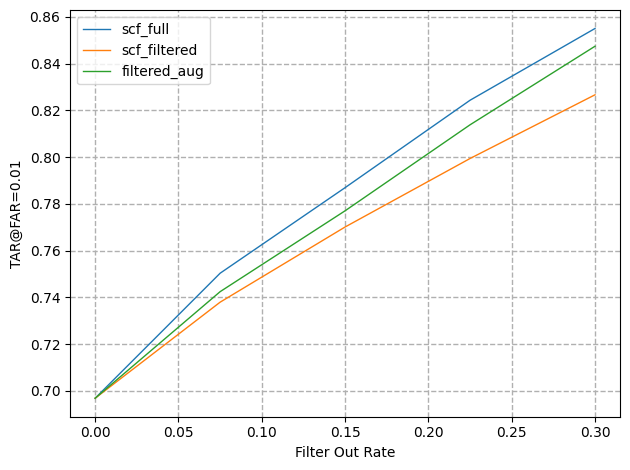

In [134]:
from evaluation.uncertainty_metrics import DisposeBasedOnUncVerif
from evaluation.metrics import TarFar

fractions = [0, 0.3, 5]
metric_to_monitor = TarFar(far_range=[-6, 0, 0.1], display_fars=[1e-3, 1e-2])
unc_metric = DisposeBasedOnUncVerif(
    fractions=fractions, metric_to_monitor=metric_to_monitor
)
full_unc_metrics = unc_metric(
    scores=scores, labels=pairs["is_positive"].values, predicted_unc=unc_full
)
filtered_unc_metrics = unc_metric(
    scores=scores, labels=pairs["is_positive"].values, predicted_unc=unc_filtered
)
aug_unc_metrics = unc_metric(
    scores=scores, labels=pairs["is_positive"].values, predicted_unc=unc_aug
)

for metric_name in full_unc_metrics:
    if metric_name == "fractions":
        continue

    metric_scores = []
    model_names = []
    model_names.append("scf_full")
    model_names.append("scf_filtered")
    model_names.append("filtered_aug")
    metric_pretty_name = metric_name.split(":")[-1]
    metric_scores.append((full_unc_metrics["fractions"], full_unc_metrics[metric_name]))
    metric_scores.append(
        (full_unc_metrics["fractions"], filtered_unc_metrics[metric_name])
    )
    metric_scores.append((full_unc_metrics["fractions"], aug_unc_metrics[metric_name]))
    fig, rejection_metric_values = plot_rejection_scores(
        scores=metric_scores,
        names=model_names,
        y_label=f"{metric_pretty_name}",
    )
    fig.show()
    # plt.close(fig)

In [ ]:
# mnist_ds_train_vis = datasets.MNIST(
#     root="/app/datasets/mnist", train=True, download=True
# )
# num_row = 5
# num_col = 5

# # plot images
# fig, axes = plt.subplots(num_row, num_col, figsize=(1.5 * num_col, 2 * num_row))
# for i in range(num_row * num_col):
#     id = conf_sort[i]
#     ax = axes[i // num_col, i % num_col]
#     ax.imshow(mnist_ds_train_vis[id][0], cmap="gray")
#     ax.set_title(f"Conf: {str(np.round(train_kappa[id], 4))}")
# plt.tight_layout()
# plt.show()

In [ ]:
# import matplotlib.pyplot as plt

# # mnist_ds_train_vis = datasets.MNIST(
# #     root="/app/datasets/mnist", train=True, download=True)
# num_row = 10
# num_col = 5

# # plot images
# fig, axes = plt.subplots(num_row, num_col, figsize=(1.5 * num_col, 2 * num_row))
# for i in range(num_row * num_col):
#     id = conf_sort[-i - 1]
#     ax = axes[i // num_col, i % num_col]
#     ax.imshow(mnist_ds_train_vis[id][0], cmap="gray")
#     ax.set_title(f"Conf: {str(np.round(train_kappa[id], 4))}")
# plt.tight_layout()
# plt.show()

#### Verification protocol

In [ ]:
# test_dl = DataLoader(
#     mnist_ds_test,
#     batch_size=128,
#     shuffle=False,
#     drop_last=False,
#     num_workers=32,
# )
# predicted_test_features, test_labels = predict_features(arcface_model, test_dl)
# first_template = []
# second_template = []
# is_positive = []
# for i in tqdm(range(len(mnist_ds_test))):
#     for j in range(len(mnist_ds_test)):
#         if i <= j: continue
#         first_template.append(i)
#         second_template.append(j)
#         is_positive.append(test_labels[i] == test_labels[j])
# first_template = np.array(first_template)
# second_template = np.array(second_template)
# is_positive = np.array(is_positive)
# pairs = pd.DataFrame(
#     {
#         "first_template": first_template,
#         "second_template": second_template,
#         "is_positive": is_positive,
#     }
# )
# pairs.to_csv("pairs.csv", index=False)

# predicted_test_features, test_labels = predict_features(arcface_model, test_dl)
# pairs = pd.read_csv("outputs/pairs.csv")
# def distance_function(X_1, X_2):
#     return np.sum(X_1 * X_2, axis=1)


# p1 = pairs["first_template"].values
# p2 = pairs["second_template"].values

# batch_size = 10000
# steps = int(np.ceil(len(p1) / batch_size))
# scores = []
# for id in tqdm(range(steps), "Verification"):
#     feat1 = predicted_test_features[p1[id * batch_size : (id + 1) * batch_size]]
#     feat2 = predicted_test_features[p2[id * batch_size : (id + 1) * batch_size]]
#     scores.extend(distance_function(feat1, feat2))
# scores = np.array(scores)

# from evaluation.visualize import draw_score_distr_plot

# is_positive = pairs["is_positive"].values

# true_match_scores = scores[is_positive]
# wrong_match_scores = scores[is_positive == 0]
# scores_distr = {
#     "Истинная пара": true_match_scores,
#     "Ложная пара": wrong_match_scores,
# }
# draw_score_distr_plot(
#     scores_distr=scores_distr,
#     positive_pair_name="Истинная пара",
#     negative_pair_name="Ложная пара",
# )